# Missing Persons Report in Alabama
### A civic data project and lesson in screen scraping & handling messy data

A friend & psychologist intuited that there's been an increase in reporting on missing persons of color in Alabama. She wondered whether or not this reflected an actual trend or if the media is simply increasing a spotlight on these cases. 

Alabama doesn't make a clear time series of missing persons cases available, but they do report cases individually on their website: [Missing Persons Cases](https://app.alea.gov/Community/wfSearch.aspx?Type=20)

The website doesn't limit records per page, so this provides a way to access and process the data without having to build a web crawler. In fact, all of the functionality needed to access the data can be found in pandas. 

In [1]:
import pandas as pd  # for web scraping and data analysis
import matplotlib.pyplot as plt  # for data visualization

plt.style.use("fivethirtyeight")  # easy to read visualization style
pd.set_option("max_colwidth", 200)  # full visibility of text fields in pandas 

Because we're pulling directly from the web, we'll use pandas's read_html() method, which scans a page for HTML tables and parses them into a *list* of *DataFrames*. 

In [2]:
# Prep to pass URL into the read_html() method

path = "https://app.alea.gov/Community/wfSearch.aspx?Type=20"
tables = pd.read_html(path)

In [3]:
number_tables = len(tables)
print(f"The method found {number_tables} tables on the page. Here are the first two:\n\n", tables[:2])

The method found 719 tables on the page. Here are the first two:

 [                                                                                                                                                                                                         0  \
0  Alabama Law Enforcement AgencyCommunity Information Center  Skip Navigation Links  HomeMissing Persons  Search Amber AlertsSearch Emergency Missing Child AlertsSearch Missing ChildrenSearch Missin...   
1                                                                                                                                                                                                      NaN   
2                                                                                                                                                                   © 2019  Alabama Law Enforcement Agency   

                                                                                                           

In [4]:
# Here is the first table after the intro line in DataFrame form
tables[5]

,0,1,2
0,NaN,Category: Missing Status: Active Date Last Seen: 11/28/2018 Date Issued: 12/23/2019,"Name: Goldsmith ,Lakira Race: Black Ethnicity: Black Gender: Female Last Seen: Montgomery, Alabama Status: Missing"


Notice that the line above corresponds to the first entry on the web page. This is true for index positions in increments of 6 afterwards as well. For example (below)

In [5]:
pd.concat(tables[5:20:5])

,0,1,2
0,NaN,Category: Missing Status: Active Date Last Seen: 11/28/2018 Date Issued: 12/23/2019,"Name: Goldsmith ,Lakira Race: Black Ethnicity: Black Gender: Female Last Seen: Montgomery, Alabama Status: Missing"
0,NaN,Category: Missing Status: Active Date Last Seen: 12/10/2019 Date Issued: 12/20/2019,"Name: Sceurman ,David Lee Race: White Ethnicity: White Gender: Male Last Seen: Mobile, Alabama Status: Missing"
0,NaN,Category: Missing Status: Active Date Last Seen: 12/09/2019 Date Issued: 12/20/2019,"Name: Hargrove ,Christy Nichole Race: White Ethnicity: White Gender: Female Last Seen: Colbert County, Alabama Status: Missing"


In [6]:
missing = pd.concat(tables[5::5]).reset_index(drop=True).iloc[:, 1:]  # This pulls each entry from the page in increments of 6 lines 
                                                                      # then concatenates into a single DataFrame
    
missing.iloc[115]  # This is what each row of raw data looks like. It may look like a challenge to work with, but there's enough info
                   # here to construct a working time series of missing persons

1                              Category:  Endangered  Status:  Active  Date Last Seen:  06/01/2000  Date Issued:  06/01/2000
2    Name:  Sparks ,Barbara McRae  Race:  White  Ethnicity:  Unknown  Gender:  Female  Last Seen:  Alabama  Status:  Missing
Name: 115, dtype: object

In [7]:
# Starting with constructing a time series.

time_regex = r"(Date Last Seen:  .{10} )"  # regex pattern which pulls the text for "date last seen"
date = pd.to_datetime(missing[1].str.extract(time_regex)[0].str.replace("Date Last Seen:  ", ""))  # converts these values into a time series

In [8]:
# regex pattern to extract locations

city_regex = r"(Last Seen:.*?,)"
city = missing[2].str.extract(city_regex)[0].str.replace(r",|Last Seen:", "").str.strip()

# regex pattern to extract race data

race_regex = r"(Race: .\w*)"
race = missing[2].str.extract(race_regex)[0].str.replace("Race:", "").str.strip()

# combine these values into a DataFrame and grab summary statistics
missing_frame = pd.DataFrame({"city": city, "race": race, "date": pd.to_datetime(date)}).set_index("date").sort_index()
missing_frame.describe()

,city,race
count,95,143
unique,62,3
top,Mobile,White
freq,10,97


In [9]:
missing_frame.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 143 entries, 1980-08-12 to NaT
Data columns (total 2 columns):
city    95 non-null object
race    143 non-null object
dtypes: object(2)
memory usage: 3.4+ KB


Taking the three year average, we can see that there's a rising trend of missing persons of color, potentially nearing the peak experienced in 2005.

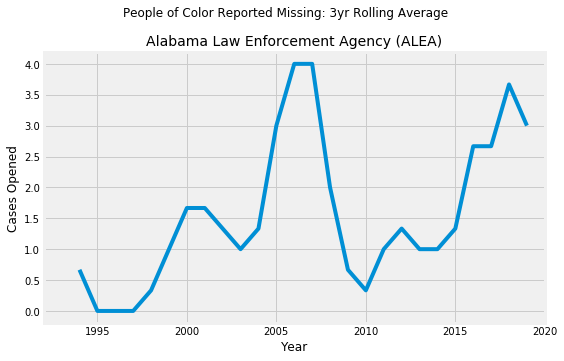

In [10]:
missing_poc = missing_frame.loc[missing_frame.race != "White"].resample(rule="y").race.count()
missing_resampled_3yr_ma = missing_poc.rolling(window=3).mean()

def alea_plotter(time_series, test_type):
    """Consistent plotting for time series tests with ALEA data"""
    
    time_series.plot(grid=True, figsize=(8, 5))
    plt.xlabel("Year")
    plt.ylabel("Cases Opened")
    plt.suptitle(f"People of Color Reported Missing: {test_type}", y=1.005)
    plt.title("Alabama Law Enforcement Agency (ALEA)", fontsize=14)
    plt.xticks(["1995", "2000", "2005", "2010", "2015", "2020"]);
    
alea_plotter(time_series=missing_resampled_3yr_ma, test_type = "3yr Rolling Average")

### Interpreting the Cases Opened Over Time

Based on the chart above, whether or not to heighten awareness and increase efforts in preventing missing persons cases is debateable. Mountain Scott, a data science enthusiast, pointed out that we can see that over the lifespan of the data, the highs are cancelled by the lows. 

Although this is true, we can see that this happens over a large period of time. With the recent trend upward, the question really is how long that trend is expected to last. We can use Autocorrelation to make assumptions to this effect.

Autocorrelation simply asks the question, "How much does past data predict future data?"

Observing the chart below, for 0 years of lag, we see what we'd expect: the data is perfectly correlated with itself. Shifting the lag outwards, we see the correlation decline, which makes sense. The more years out, the harder it is to use previous data to predict the value. 

Text(0, 0.5, 'Correlation')

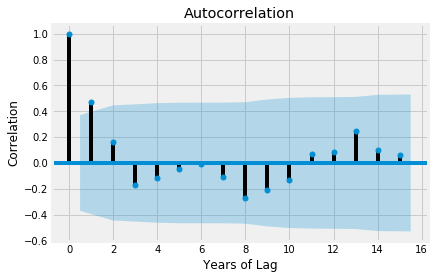

In [11]:
from statsmodels.graphics.tsaplots import plot_acf
acf = plot_acf(missing_poc)
plt.xlabel("Years of Lag")
plt.ylabel("Correlation")

## Conclusion

There is much more data that can be extracted and analyzed from the site, but the core message is clear. We should be vigilant and watchful of our neighbors and make sure that we're protecting others in our communities. Recent spikes indicate that in the short-term years to come, these cases could remain high, with the potential to decline over the long run. 

The following information is available on the site to help report these issues:

If you think you have seen a missing person or have any information, contact the agency listed in our database or contact the Alabama Law Enforcement Agency Center for Missing and Exploited Children directly at (800) 228-7688. Our business hours are 8:00am cst - 5:00pm cst, Monday - Friday. 

Please limit after hour calls to emergencies only. 

Callers without access to the US 800 telephone system should call 001-334-353-1172. Our E-MAIL: missing@alea.gov.

### Additional Note

Often, datasets related to important social & business issues are hard to find or non-existent. As an analyst or data scientist, you have a wide range of tools and options available to mine data sources and find key insights. When working with stakeholders, be sure to bring an optimistic spirit and open mind to the table. Tasks that look impossible at first may end up having attainable solutions. 

Some good basics to have in addition to a positive attitude: python, pandas, regex, matplotlib, statsmodels, sklearn. Hit me up at @luketrailrunner if you need any guidance on resources to learn these packages. 